# Ripple-associated CG spectral analysis
https://github.com/Eden-Kramer-Lab/spectral_connectivity/blob/master/examples/Intro_tutorial.ipynb

<br>

### Imports

In [1]:
import os
import re
import glob
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from spectral_connectivity import Multitaper, Connectivity

warnings.filterwarnings('ignore')

<br>

### Define functions

In [351]:
def split_by_phase(df):
    
    sample_df = df.loc[df['phase']=='Sample'].drop(['phase'], axis=1)
    delay_df = df.loc[df['phase']=='Delay'].drop(['phase'], axis=1)
    test_df = df.loc[df['phase']=='Test'].drop(['phase'], axis=1)
    iti_df = df.loc[df['phase']=='ITI'].drop(['phase'], axis=1)
    
    return sample_df, delay_df, test_df, iti_df


def prepare_for_multitaper(df, n_tts):
    '''
    Rearrange and prepare data for multitaper.
    df, Dataframe. 
    n_tts, int - Number of tetrodes (may vary with dataset)
    '''
    
    # Normalise relative timestamp to correct small jitters
    #df['relative_timestamp']=df.relative_timestamp.round(8)

    # Drop unecessary columns
    to_drop = ['start_time', 'end_time','timestamp']#, 'relative_timestamp']
    df = df.drop(to_drop, axis=1)

    # Create TT list
    tts = ['TT{}'.format(x) for x in range(1,n_tts+1)]
    
    # Re-shape dataset into array    
    reshaped = df.pivot_table(
        index='i',#'relative_timestamp',#"bin_centres", 
        columns="ripple_nr", 
        values=tts,
        dropna=False
    ).values.reshape(
        (
        df['i'].nunique(),
        df['ripple_nr'].nunique(), # number of ripples
        n_tts
        )
    )
    
    return reshaped


def get_conn (df, fs, window, step, exp_type, nblocks, time_halfbandwidth_product):
    
    '''
    Prepares dataframe provided for multitaper
    Creates a multitaper object
    Inputs the multitaper object to create a connectivity object.
    '''
    
    multitaper = Multitaper(
        df, 
        sampling_frequency=fs, 
        n_time_samples_per_window = window,
        n_time_samples_per_step = step,
        time_halfbandwidth_product = time_halfbandwidth_product
    )
        
        
    conn = Connectivity.from_multitaper(
        multitaper, 
        expectation_type = exp_type, 
        blocks = nblocks
    )
    
    return conn   


def get_average_power(conn):
    
    '''
    Average power across tetrodes.
    conn, connectivty object. 
    '''  
    
    # Get time labels
    times = conn.time
    
    # Get frequencies
    freqs = conn.frequencies
    
    # Calculate power ((A,B,C,D) --> A) Time windows; B) trials; C) Frequencies; D) Tetrodes)
    power = conn.power()   
      
    # Average across tetrodes and SWRs
    # Resource: https://numpy.org/doc/stable/reference/generated/numpy.nanmean.html
    averaged_power= np.nanmean(power, axis=(3,1))

    # Get standard deviations across tetrodes and SWRs
    std_power= power.std(axis=(3,1))
    
    return freqs, times, averaged_power, std_power, power

def create_psd(t, f, xx, decibel_scaling, title, vmin, vmax):
    
    '''
    Create the PSD plot for given dataset. 
    Returns fig object.
    t - array, times
    f - array, frequencies
    xx - array, power
    decibel_scaling - boolean, to perform decibel scaling on data
    title - the title of the plot,
    vmin - minimum power value
    vmax - maximum power value
    '''
    
    # If decibel scaling is requested
    if decibel_scaling == True:
        xx =np.log10(xx/np.max(xx))
        
    print('Min db: ', np.min(xx), '<br> Max db: ', np.max(xx))
    
    fig, ax = plt.subplots(figsize=(6,3))
    ax.mesh = plt.pcolormesh(
        t,
        #np.subtract(iti_times,.5),
        f,
        xx.squeeze().T,
        cmap="jet",
        shading="auto",
        vmin = vmin,
        vmax = vmax
    )

    # Add vertical line
    plt.axvline(0.5, color='black', linestyle=':')
    
    
    # Define axes labels
    plt.ylabel('Frequencies (Hz)')
    plt.xlabel('Time to event (s)')
    
    # Define title
    plt.title(title)
      
    # Define axes limits
    plt.ylim((0,100))
    plt.xlim((0, 1))

    # Add color bar
    cb = fig.colorbar(
        ax.mesh,
        orientation="vertical",
        shrink=0.5,
        aspect=15,
        pad=0.05,
        label="Power (db)"
    )
    
    sns.despine()

In [373]:

def prepare_for_band_plots (arr, t, freqs, phase):
    
    '''    
    Prepares data for band plots by converting it to a dataframe structure, accepted by seaborn.
    
    arr, np.array - The power containing array
    times, np.array - The time labels. Range from 0 to 1(sec)
    freqs, np.array - The frequency windows
    phase, str - The phase to which the data refers to.
    output:
    df, pd.DataFrame - The reorganized dataframe    
    '''

    # Re-calculate average across tetrodes (not trials)from power 
    # essencially I will re-do average across trials in seaborn
    p= np.nanmean(arr, axis=(3)) #only across tetrodes
    
    melted_list = []
    
    for i in range(0, p.shape[0]):
    
        # Power data per freq x trial for each time window
        xx = pd.DataFrame(p[i,:,:], columns=list(freqs))
        melted = xx.melt(value_vars=xx, value_name='power', var_name='freq')
        melted['time'] = t[i]
        melted_list.append(melted)
      
    df= pd.concat(melted_list)
    
    
    # Excludes time of SWR detection
    df.loc[(df.time >= .2) & (df.time < .3), 'time_band'] = '0.2-0.3s'
    df.loc[(df.time >= .3) & (df.time < .4), 'time_band'] = '0.3-0.4s'
    df.loc[(df.time >= .4) & (df.time < .5), 'time_band'] = '0.4-0.5s'
    
    df.loc[(df.time > .5) & (df.time <= .6), 'time_band'] = '0.5-0.6s'
    df.loc[(df.time > .6) & (df.time <= .7), 'time_band'] = '0.6-0.7s'
    df.loc[(df.time > .7) & (df.time <= .8), 'time_band'] = '0.7-0.8s'    
    
    # Labelling of phase
    df['phase'] = phase
    
    # Decibel scaling of power
    df['power_db'] =np.log10(df['power']/np.max(df['power']))
    
    # Label frequency windows   
    df.loc[ df.freq == 5, 'freq_band'] = 'Theta (5-10Hz)'
    df.loc[ df.freq.between(30,40), 'freq_band'] = 'Slow Gamma (30-50 Hz)'  
    df.loc[ df.freq.between(50, 90), 'freq_band'] = 'Fast Gamma (50-90Hz)'
               
    return df
    

<br>

### Open datasets

In [353]:
main_path = 'PreProcessedData'
cg_data = pd.read_csv(os.path.join(main_path, 'cg_data.csv'), index_col=False)
ripple_data = pd.read_csv(os.path.join(main_path, 'cg_analysis_ripple_library.csv'), index_col=False)

In [354]:
cg_data.loc[(cg_data['phase']=='Test (Pre-choice)')|(cg_data['phase']=='Test (Past-choice)'), 'phase']='Test'

In [355]:
# Calculate i, a cumulative count of rows per ripple
cg_data['i']=cg_data.groupby(['ripple_nr']).cumcount()

<br>

### Split dataset according to sampling rates & phase

In [356]:
# Currently the only session with 20K sampling
# ripple_data.loc[ripple_data.session_code == 20191113131818, 'ripple_nr'].unique() -- TO DROP AFTER REPROCESSING
#cg_data_2k = cg_data[cg_data.ripple_nr.between(0,74)]

In [357]:
cg_data = cg_data[ ~ cg_data.ripple_nr.between(0,74)]  ## ---- TO DROP AFTER REPROCESSING

In [358]:
cg_data.groupby(['phase']).ripple_nr.nunique()

phase
Delay     114
ITI        98
Sample    186
Test      155
Name: ripple_nr, dtype: int64

In [359]:
# Split by phase
#sample_2k, delay_2k, test_2k, iti_2k = split_by_phase(cg_data_2k)
sample, delay, test, iti = split_by_phase(cg_data)

<br>

### Create connectivity object

In [360]:
## I NEED TO REPROCESS ALL 30Ks TO HAVE 20Ks - SO THAT ALL SAMPLES HAVE 5K / sec

#### 1. Prepare for multitaper
"If we have three dimensions, dimension 1 is time, dimension 2 is trials, and dimensions 3 is signals. It is important to know note that dimension 2 now has a different meaning in that it represents trials and not signals now. Dimension 3 is now the signals dimension. We will show an example of this later." time_series : array, shape (n_time_samples, n_trials, n_signals).

In [361]:
n_tts =14

In [362]:
reshaped_iti = prepare_for_multitaper(iti, n_tts= n_tts)
reshaped_sample = prepare_for_multitaper(sample, n_tts= n_tts)
reshaped_delay = prepare_for_multitaper(delay, n_tts= n_tts)
reshaped_test = prepare_for_multitaper(test, n_tts= n_tts)

<br>

#### 2.Create conn objects
##### 2.1 Create multitaper object

Controls the duration of the segment of time the transformation is computed on (seconds)
w_duration = 0.1
Control how far the time window is slid (overlap).
Setting the step to smaller than the time window duration will make the time windows overlap
step = 0.02
Controls the frequency resolution of the Fourier transformed signal.
Setting this parameter will define the default number of tapers used in the transform 
(number of tapers = 2 * time_halfbandwidth_product - 1.).
Need to study this one although setting the above automatically changes this one
time_halfbandwidth_product = 10

##### 2.2. Create connectivity object
The Connectivity class computes the frequency-domain connectivity measures from the Fourier coeffcients.

In [363]:
fs = 3000
window = 600 #200ms
step = 60 #20 ms
nblocks = 30
exp_type = "tapers"
time_halfbandwidth_product= 1 # Check what this is

In [364]:
iti_conn = get_conn(
    reshaped_iti,
    fs= fs, 
    window=window, 
    step=step, 
    time_halfbandwidth_product= time_halfbandwidth_product,
    exp_type=exp_type,
    nblocks=nblocks
)

sample_conn = get_conn(
    reshaped_sample,
    fs= fs, 
    window=window, 
    step=step, 
    time_halfbandwidth_product= time_halfbandwidth_product,
    exp_type=exp_type,
    nblocks=nblocks
)

delay_conn = get_conn(
    reshaped_delay,
    fs= fs, 
    window=window, 
    step=step, 
    time_halfbandwidth_product= time_halfbandwidth_product,
    exp_type=exp_type,
    nblocks=nblocks
)

test_conn = get_conn(
    reshaped_test,
    fs= fs, 
    window=window, 
    step=step, 
    time_halfbandwidth_product= time_halfbandwidth_product,
    exp_type=exp_type,
    nblocks=nblocks
)

<br>


### Calculate aggregated power metrics for each SWR type

In [365]:
iti_freqs, iti_times, iti_mean_power, iti_std, iti_power= get_average_power(iti_conn)
sample_freqs,sample_times, sample_mean_power, sample_std, sample_power = get_average_power(sample_conn)
delay_freqs, delay_times, delay_mean_power, delay_std, delay_power = get_average_power(delay_conn)
test_freqs, test_times, test_mean_power, test_std, test_power = get_average_power(test_conn)

In [366]:
test_freqs.shape, test_times.shape, test_times.max(), test_freqs.max()

((300,), (41,), 0.8, 1495.0)

<br>

# Power spectral density plot

Decibels scaling info [here](https://mark-kramer.github.io/Case-Studies-Python/03.html#step-5-decibel-scaling).

Min db:  -4.294880942673699 <br> Max db:  0.0


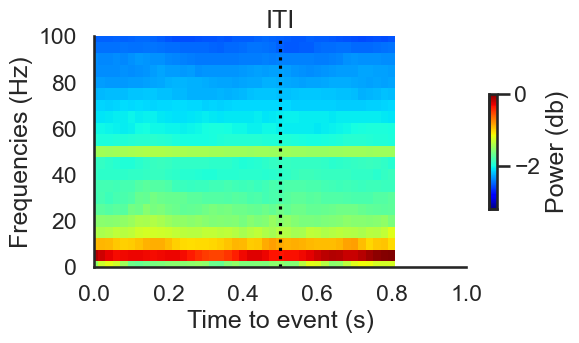

In [367]:
create_psd(
    iti_times, iti_freqs, iti_mean_power, decibel_scaling=True, title='ITI', vmin=-3.2, vmax=0
)
#plt.savefig(fname=, dpi=300, format='svg' )

Min db:  -4.681188117825327 <br> Max db:  0.0


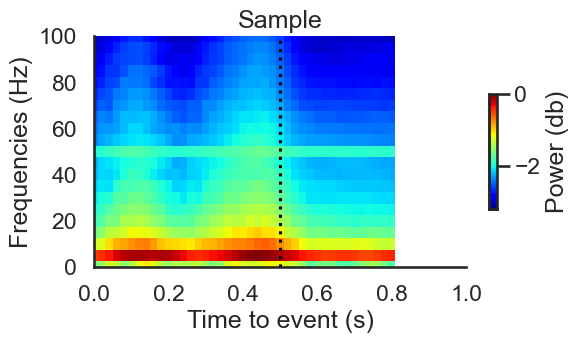

In [368]:
create_psd(
    sample_times, sample_freqs, sample_mean_power, decibel_scaling=True, title='Sample',  vmin=-3.2, vmax=0
)
#plt.savefig(fname=, dpi=300, format='svg' )

Min db:  -4.703508187119119 <br> Max db:  0.0


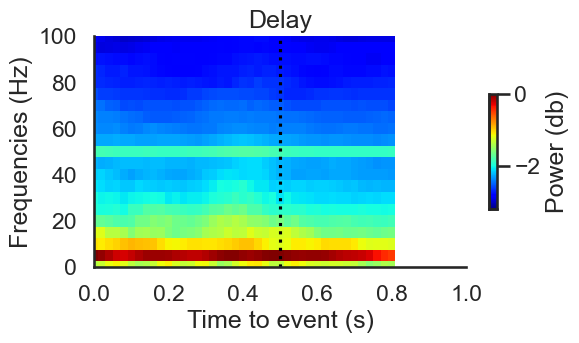

In [369]:
create_psd(
    delay_times, delay_freqs, delay_mean_power, decibel_scaling=True, title='Delay',  vmin= - 3.2, vmax=0
)
# plt.savefig(fname=, dpi=300, format='svg' )

Min db:  -4.32631906002297 <br> Max db:  0.0


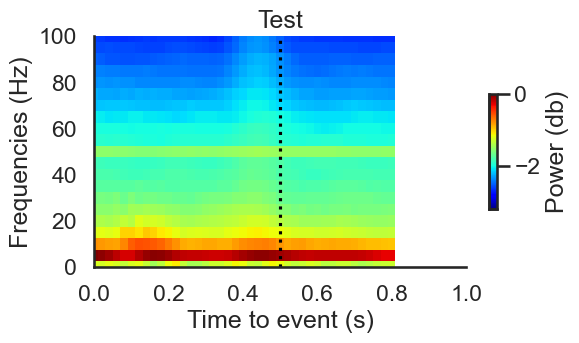

In [370]:
create_psd(
    test_times, test_freqs, test_mean_power, decibel_scaling=True, title='Test', vmin=-3.2, vmax=0
)
# plt.savefig(fname=, dpi=300, format='svg' )

<br>

### Power by bands
Bands of interest:
theta, 5-9 Hz
low gamma (LG), 31-48 Hz
high gamma (HG) 52-95 Hz

<br> 

# Plot frequency-specific power in time bands

Confirm value of freq_band is the value of freq window start. - but most likely
IMPORTANT: CHECK WHY SO MANY NANS

<br>

### Prepare datasets for band plots
Converts array data into a dataframe for seaborn input.

Labels time and frequency bands of interest to plot.

Concatenates all data into single dataframe.

In [382]:
# Time interval boundaries to analyse
t_lower = .3
t_upper = .7

# Prepare data
iti_data = prepare_for_band_plots(iti_power, iti_times, iti_freqs,'ITI')
sample_data = prepare_for_band_plots(sample_power, iti_times, iti_freqs,'Sample')
delay_data = prepare_for_band_plots(delay_power, delay_times, delay_freqs,'Delay')
test_data = prepare_for_band_plots(test_power, test_times, test_freqs,'Test')

# Concatenate into single dataframe
data = pd.concat([iti_data, sample_data, delay_data, test_data]).reset_index()

<br>

### Plot power in specific frequency bands of interest

In [495]:
def plot_freq_bands_power(df, freq_band):
    '''
    Plots averaged power (db) across time windows for specific provided freq_band
    df, pd.DataFrame - Thedataframe containing data 
    freq_band - The label of the frequency band to plot
    '''
    width = 20
    height = 4
    
    # Get power for frequency band of interest
    sns.set(context='talk', style='white', rc={"lines.linewidth": 1})#, 'figure.figsize':(width, height)})
    #plt.Figure(figsize=(8,16))
    
    spectral = sns.color_palette('Spectral', 12)
    p = [spectral[0], spectral[2], spectral[4], spectral[10]]

    g = sns.catplot(
        kind='point',
        aspect=1,
        data = data[data.freq_band==freq_band], 
        x='time', 
        y='power_db',
        hue='phase',
        col = 'phase',
        col_wrap=2,
        estimator = np.mean,
        errorbar = 'sd',
        palette = p,
        dodge = .3
    )

    g.set_axis_labels("Time (s)", "Power (db)")
    g.set(xticks=np.arange(0, len(data.time.unique())+1, 10))
    
    axes = g.axes.flatten()
    for ax in axes:
        ax.axvline(20, color='black', linestyle=':', linewidth=2)   ##WILL BE IN THE MIDDLE ONDE TIME INTERVAL INCREASES
        
    axes[0].set_title("ITI")
    axes[1].set_title("Sample")
    axes[2].set_title("Delay")
    axes[3].set_title("Test")
    
    
    sns.despine()

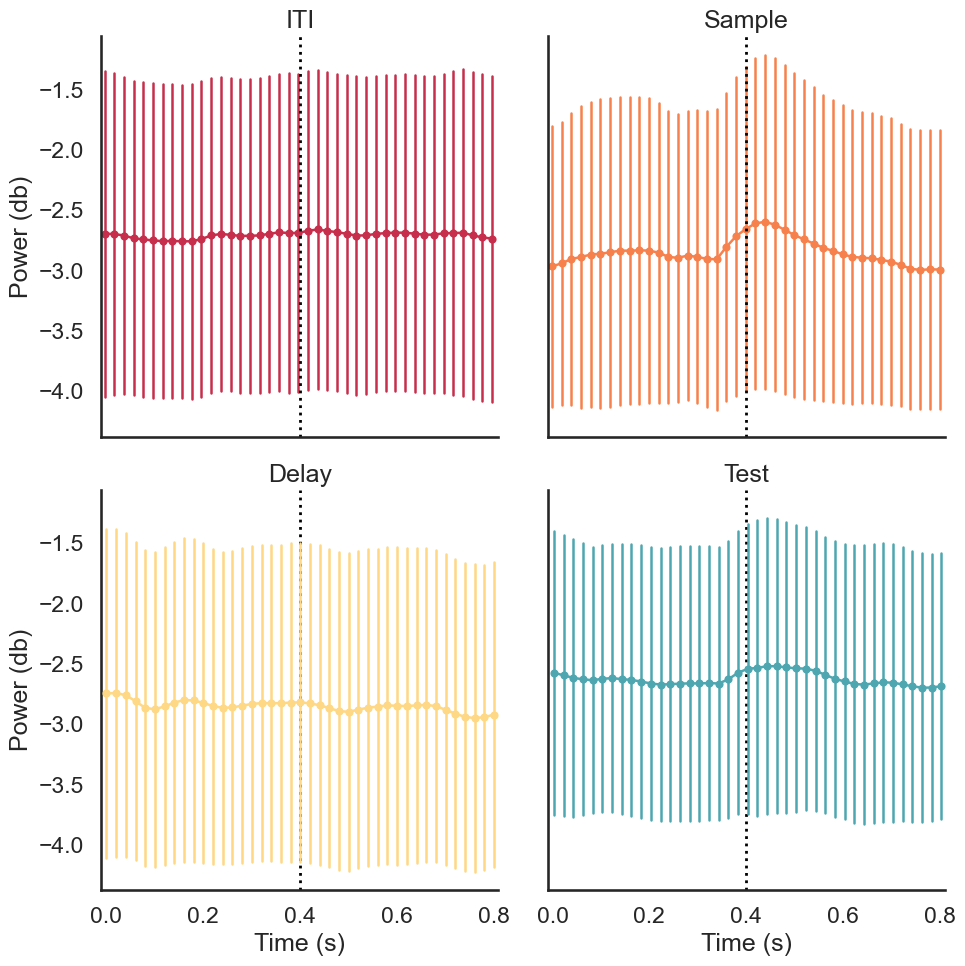

In [496]:
plot_freq_bands_power(data, 'Theta (5-10Hz)')

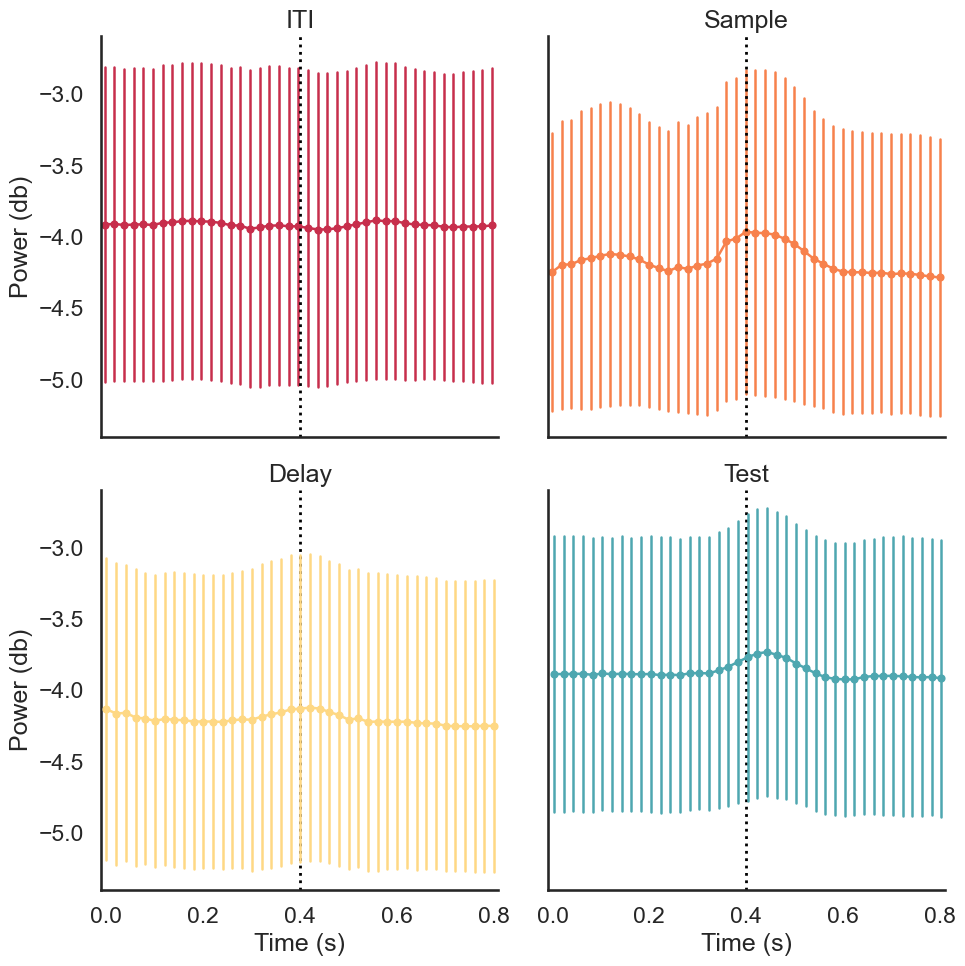

In [497]:
plot_freq_bands_power(data, 'Slow Gamma (30-50 Hz)')

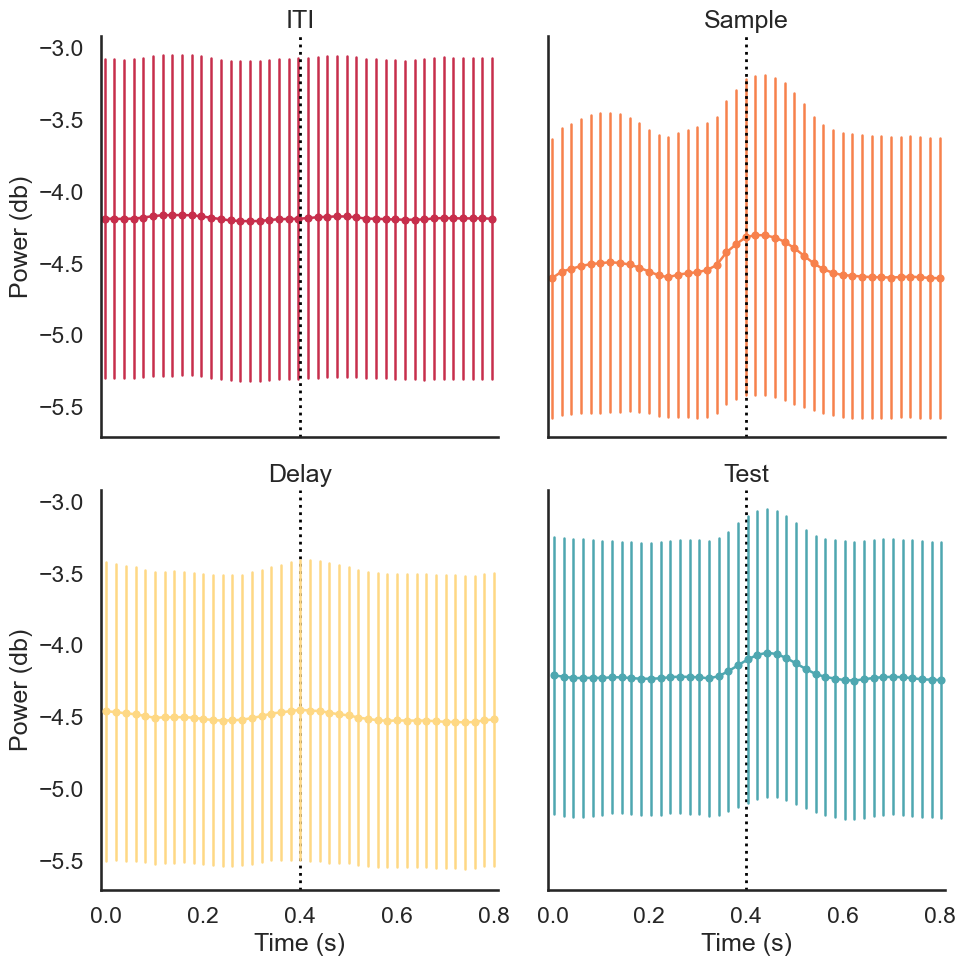

In [498]:
plot_freq_bands_power(data, 'Fast Gamma (50-90Hz)')

<br>

### Statistical testing

We want to assess the impact of SWR occurrence of CG activity across multiple bands which means we want to assess impact of time intervals in power changes for each band and for each phase.

Parametric test = repeated measures one way ANOVA (implementation [here](https://www.geeksforgeeks.org/how-to-perform-a-repeated-measures-anova-in-python/))

Non parametric alternative = The Friedman test (implementation [here](https://www.statology.org/friedman-test-python/)